# Shakespeare: Recommendation and Text Analysis

Author: Ralph Parlin

Many believe William Shakespeare is considered one of the greatest playwrights in the English language. He is attributed with 38 plays, 154 sonnets, and other works. Even 400 years later, his writings are still be studied in most high schools and colleges in the US and elsewhere. Shakespeare’s complete works are available online at http://shakespeare.mit.edu/. This analysis uses a data set which has Shakespeare character quotes. A lot of people are fascinated by the characters in the Shakespeare plays. The first first part of the analysiscreates a Shakespeare character recommender system which is capable of recommending new characters which are similar to a speicific character of interest. This analysis also explores using PCA inference to find important words in character quotes. LAstly, this analysis uses K-Means clustering to try and find one or more character insights.

## Note that this notebook is expected to run in the Google Colab environment

## Create the Environment

Note, if you don't have spark, run this file on Colab.


In [1]:
# Only Run this if you are using Colab
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

# Download the data files from github
# If the data file does not exist in the colab environment
if [[ ! -f ./diamonds.csv ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/Rparlin/DS_Projects/main/Shakespeare_Recommendation_and_Text_Analysis/quotes_by_chars.csv
   
fi

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=1ff6d7fbcc07c2e0124716498b93b12a40e2840362e122f39fcb1251dddf0990
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


--2020-11-14 17:33:06--  https://raw.githubusercontent.com/Rparlin/DS_Projects/main/Shakespeare_Recommendation_and_Text_Analysis/quotes_by_chars.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4201044 (4.0M) [text/plain]
Saving to: ‘quotes_by_chars.csv’

     0K .......... .......... .......... .......... ..........  1% 4.04M 1s
    50K .......... .......... .......... .......... ..........  2% 12.1M 1s
   100K .......... .......... .......... .......... ..........  3% 4.64M 1s
   150K .......... .......... .......... .......... ..........  4% 20.1M 1s
   200K .......... .......... .......... .......... ..........  6% 5.95M 1s
   250K .......... .......... .......... .......... ..........  7% 15.6M 1s
   300K .......... .......... .......... .......... ......

In [2]:
# import statements
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

## Read the data file into a spark data frame

# Part 1: Shakespeare Recommendation System

In [3]:
# Import statements
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.feature import IDF
from pyspark.sql import functions as fn, Row
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
# Load data into a spark dataframe
quotes_by_char_df = spark.read.option("inferSchema", "true").option("header", "true").csv("quotes_by_chars.csv")

In [5]:
# Inspect the import
quotes_by_char_df.show(5)

+---+-----------+--------------------+
|_c0|  character|          all_quotes|
+---+-----------+--------------------+
|  0|        & C|Well met, Master ...|
|  1|     A Lord|     Sir, it was I. |
|  2|A Patrician|This man has marr...|
|  3|   A Player|So please your lo...|
|  4|      AARON|Now climbeth Tamo...|
+---+-----------+--------------------+
only showing top 5 rows



In [6]:
# Inspect the scheme and datatypes
quotes_by_char_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- character: string (nullable = true)
 |-- all_quotes: string (nullable = true)



In [7]:
# More dataframe inspection
from pyspark.sql import functions as fn # import functions
print("Number of Observations:",quotes_by_char_df.count())
print("Number of Columns:",len(quotes_by_char_df.columns))
print("Number of Columns with real data (less the index column):",(len(quotes_by_char_df.columns)-1))

Number of Observations: 966
Number of Columns: 3
Number of Columns with real data (less the index column): 2


In [8]:
# Drop the Unnamed Column as instructed
drop_col = ["_c0"]
quotes_by_char_df = quotes_by_char_df.drop(*drop_col)

In [9]:
# Transform the 'character' column such that all character names are lower case
from pyspark.sql.functions import col, lower, regexp_replace, split

quotes_by_char_df = quotes_by_char_df.withColumn("character", lower("character"))

In [10]:
# Inspect the work
display(quotes_by_char_df.toPandas().head())

,character,all_quotes
0,& c,"Well met, Master Ford."
1,a lord,"Sir, it was I."
2,a patrician,This man has marr'd his fortune. You do the no...
3,a player,So please your lordship to accept our duty. I ...
4,aaron,"Now climbeth Tamora Olympus' top, Safe out of ..."


## Clean Data and create inital PCA Pipeline

In [11]:
# Before establishing the pipeline I'll clean the data to perform better scoring
from pyspark.sql.functions import col, lower, regexp_replace, split
# Develop clean-up funciton

def clean_text(t): 
    t = lower(t) # move all letters to lowercase
    t = regexp_replace(t, "[^a-z0-9\\s]", "") # remove all things that are not included in this range
    t = regexp_replace(t, "(\s  *)", "")# remove all double and more spaces
    return t

quotes_by_char_df = quotes_by_char_df.withColumn("all_quotes", (clean_text(col("all_quotes"))))

In [12]:
# Let's inspect the data to see how the cleaning went
quotes_by_char_df.show(10)

+-----------+--------------------+
|  character|          all_quotes|
+-----------+--------------------+
|        & c|well met master f...|
|     a lord|       sir it was i |
|a patrician|this man has marr...|
|   a player|so please your lo...|
|      aaron|now climbeth tamo...|
|abergavenny|i cannot tell wha...|
|   abhorson|do you call sir a...|
|    abraham|do you bite your ...|
|   achilles|why how now ajax ...|
|       adam|yonder comes my m...|
+-----------+--------------------+
only showing top 10 rows



In [13]:
# Let's inspect to see if there are rows (chars) with more than one entry
chars = quotes_by_char_df \
    .groupby(['character']) \
    .count() \
    .where('count > 1') \
    .sort('count', ascending=False) \
    .show()

+------------------+-----+
|         character|count|
+------------------+-----+
|             lords|    2|
|   second murderer|    2|
|         courtezan|    2|
|              page|    2|
|             nurse|    2|
|             ghost|    2|
|              both|    2|
|             clerk|    2|
|posthumus leonatus|    2|
|           knights|    2|
|          gardener|    2|
|               all|    2|
|         attendant|    2|
+------------------+-----+



In [14]:
# Turns out some chars have been listed twice.  Rather than just drop duplicate chars, I want to aggregate values (quotes) for all chars.  To do so I will map/reduce.
# Map and reduce to eliminate duplicate characters and move thier quotes to reduce by key
rdd = quotes_by_char_df.rdd # covert to an rdd

rdd.take(5) # inspect the work

[Row(character='& c', all_quotes='well met master ford '),
 Row(character='a lord', all_quotes='sir it was i '),
 Row(character='a patrician', all_quotes='this man has marrd his fortune you do the nobler ay and burn too '),
 Row(character='a player', all_quotes='so please your lordship to accept our duty i think twas soto that your honour means fear not my lord we can contain ourselves were he the veriest antic in the world '),
 Row(character='aaron', all_quotes='now climbeth tamora olympus top safe out of fortunes shot and sits aloft secure of thunders crack or lightning flash advanced above pale envys threatening reach as when the golden sun salutes the morn and having gilt the ocean with his beams gallops the zodiac in his glistering coach and overlooks the highestpeering hills so tamora upon her wit doth earthly honour wait and virtue stoops and trembles at her frown then aaron arm thy heart and fit thy thoughts to mount aloft with thy imperial mistress and mount her pitch whom tho

In [15]:
# Define the map and reduce functions
def map_function(row):
  return [row[0], row [1]]

def reduce_function(value1, value2): #define reduce function
    return value1 + value2

In [16]:
# Run and inspect the MapReduce
data = rdd.map(map_function).reduceByKey(reduce_function).collect() # run functions and store the collect

#Convert the collect data to RDD
new_rdd = spark.sparkContext.parallelize(data)

new_rdd.take(5) #inspection

[('a lord', 'sir it was i '),
 ('a player',
  'so please your lordship to accept our duty i think twas soto that your honour means fear not my lord we can contain ourselves were he the veriest antic in the world '),
 ('aaron',
  'now climbeth tamora olympus top safe out of fortunes shot and sits aloft secure of thunders crack or lightning flash advanced above pale envys threatening reach as when the golden sun salutes the morn and having gilt the ocean with his beams gallops the zodiac in his glistering coach and overlooks the highestpeering hills so tamora upon her wit doth earthly honour wait and virtue stoops and trembles at her frown then aaron arm thy heart and fit thy thoughts to mount aloft with thy imperial mistress and mount her pitch whom thou in triumph long hast prisoner held fetterd in amorous chains and faster bound to aarons charming eyes than is prometheus tied to caucasus away with slavish weeds and servile thoughts i will be bright and shine in pearl and gold to wait 

In [17]:
# Now that the data has been reduced, let's put it back into a DF
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType

# Create a schema for the dataframe
schema = StructType([
    StructField('character', StringType(), True),
    StructField('all_quotes', StringType(), True)])

# Convert the RDD to a DF
quotes_by_char_df = spark.createDataFrame(new_rdd,schema)

#Inspect the work.  We should see that the DF has been reduced by 13 rows since we reduced 26 duplicates
quotes_by_char_df.printSchema()
quotes_by_char_df.show(10)

print("After conducting MapReduce of chars, we now have a DF with",quotes_by_char_df.count(), "observations rather than 966 with duplicates. Success!")

root
 |-- character: string (nullable = true)
 |-- all_quotes: string (nullable = true)

+-----------+--------------------+
|  character|          all_quotes|
+-----------+--------------------+
|     a lord|       sir it was i |
|   a player|so please your lo...|
|      aaron|now climbeth tamo...|
|abergavenny|i cannot tell wha...|
|    abraham|do you bite your ...|
|   achilles|why how now ajax ...|
|       adam|yonder comes my m...|
| alcibiades|sir you have save...|
|     alexas|soothsayer show h...|
|     alonso|good boatswain ha...|
+-----------+--------------------+
only showing top 10 rows

After conducting MapReduce of chars, we now have a DF with 953 observations rather than 966 with duplicates. Success!


In [18]:
# Create a preprocessing Pipeline

# Establish the tokenizor
tkn = feature.Tokenizer().setInputCol("all_quotes").setOutputCol("all_quotes_Out")

# Prepare a stopwords filter
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("all_quotes_Out")\
  .setOutputCol("filtered")

# Establish the count_vectorizer_estimator requiring the tf to have a word appear at least 1; MinDF is 10 in corpus
count_vectorizer_estimator = CountVectorizer(minTF=1., minDF=10.).setInputCol('filtered').setOutputCol('tf') # I orginally modified these but to reduce the time it took to conduct PCA, but I moved them back to 1/10 and it's only taking a little longer than before.

# Establish the IDF 
idf = feature.IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

# Build a scaler to center the data - no need to standardize since they are in the same units
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='tfidf', outputCol='centered_tfidf')

# Create a pipeline estimator
pre_proc_pipe = Pipeline(stages=[tkn, sw_filter, count_vectorizer_estimator, idf, center])

# Fit the fit
pre_proc_pipe_fit = pre_proc_pipe.fit(quotes_by_char_df)

# Transform with the pipe
quotes_by_char_preproc_df = pre_proc_pipe_fit.transform(quotes_by_char_df)


In [19]:
# Determine a viable number for K
# Explicitly set the K parameter in the spark PCA object equal to the maximum number of principal components, determined by using the analysis for the number of rows and cols in the data 
# There are at most min(n - 1; p) principal components where n is the number of rows and p is the number of cols
p = len(pre_proc_pipe_fit.stages[-3].vocabulary)
n = quotes_by_char_preproc_df.count()

print("p (number of columns) = ",p)
print("n (number of rows) = ", n)
k = min((n-1),p)
print("There are at most min(n - 1; p) principlal components, as such, we will set k = ", k)

p (number of columns) =  4326
n (number of rows) =  953
There are at most min(n - 1; p) principlal components, as such, we will set k =  952


In [20]:
# BASED ON MY PARAMETERS, THIS WILL TAKE APX 5 MINS TO EXECUTE

# Build a principal component object with the same number of components as k
pca = feature.PCA(k=k, inputCol='centered_tfidf', outputCol='scores')

# Create a pipeline estimator and fit it to the data
pipe_pca_1 = Pipeline(stages=[pre_proc_pipe, pca]).fit(quotes_by_char_df)

# Transform
chars_pca_df = pipe_pca_1.transform(quotes_by_char_df)

In [21]:
# Code to print the number of rows and cols (again)
print("p (number of columns) = ",p)
print("n (number of rows) = ", n)

p (number of columns) =  4326
n (number of rows) =  953


In [22]:
# Review the work
display(chars_pca_df.toPandas().head())

,character,all_quotes,all_quotes_Out,filtered,tf,tfidf,centered_tfidf,scores
0,a lord,sir it was i,"[sir, it, was, i]",[sir],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7693537893705...","[-3.842138431949547, -2.962779020975928, -1.93...","[15.936544209968046, -1.1217654448409846, 0.41..."
1,a player,so please your lordship to accept our duty i t...,"[so, please, your, lordship, to, accept, our, ...","[lordship, accept, duty, think, twas, soto, ho...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.6806470177957138, ...","[-3.842138431949547, -2.962779020975928, -1.93...","[15.511968592933254, -1.2967195029204115, 0.53..."
2,aaron,now climbeth tamora olympus top safe out of fo...,"[now, climbeth, tamora, olympus, top, safe, ou...","[climbeth, tamora, olympus, safe, fortunes, sh...","(16.0, 18.0, 13.0, 12.0, 5.0, 4.0, 1.0, 3.0, 8...","(11.5324659075525, 13.848368208670589, 6.90225...","[7.6903274756029525, 10.885589187694661, 4.970...","[-37.29236393307519, -2.3087899503708385, 6.30..."
3,abergavenny,i cannot tell what heaven hath given himlet so...,"[i, cannot, tell, what, heaven, hath, given, h...","[tell, heaven, hath, given, himlet, graver, ey...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.5309427659255902, 0.0, 0.0, 0.0, ...","[-3.842138431949547, -2.962779020975928, -1.40...","[14.597938253879793, -1.5736010403012253, 0.40..."
4,abraham,do you bite your thumb at us sir do you bite y...,"[do, you, bite, your, thumb, at, us, sir, do, ...","[bite, thumb, sir, bite, thumb, sir, quarrel, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0774151574823...","[-3.842138431949547, -2.962779020975928, -1.93...","[15.572113453776291, -0.7393535947616098, 0.14..."


## Analyze the PCA data and create scree and cumulative variance explained plots.  

In [23]:
# Access the loadings
loadings = pipe_pca_1.stages[-1].pc.toArray()

In [24]:
print("loadings.shape", loadings.shape)
# This data was standarized so these are correlations
# print the first column of the loading matrix - the first principal component
print(loadings[:,0])

loadings.shape (4326, 952)
[-0.28542251 -0.20612313 -0.11463595 ... -0.00371735 -0.00075881
 -0.0014886 ]


In [25]:
# Let's get a look at the varianced explained 
explained_var = pipe_pca_1.stages[-1].explainedVariance
print(explained_var)

[0.14783353854784573,0.03302901833910349,0.02494481772721657,0.023090885000579757,0.019215979375176523,0.01692768821307885,0.015619746689542672,0.014443516762644146,0.013927894594978755,0.01338601603948599,0.012125655434716616,0.011569159825890022,0.010883610511723995,0.010204017035753863,0.009557680412659577,0.00881984924300484,0.00859429775191477,0.008158968624166424,0.007960716648171738,0.00776843956058062,0.007521181615241771,0.0073111529139405895,0.007117942287374747,0.006989239294265852,0.0067978340823595,0.006439333957901705,0.006329368872503246,0.0060342708888147314,0.005926900503374367,0.00588900945785139,0.005730605542805929,0.005611380332026145,0.0054153427845154015,0.005366773853969148,0.00532974907525629,0.005125046643038944,0.0050380191376819695,0.004993083614994444,0.004787052179481457,0.004711458831801441,0.004654540364228934,0.004592535274658408,0.004495593079254739,0.004431552691794707,0.004314946827043898,0.004293931246201099,0.004187007401449554,0.004143954830144316

In [26]:
# And let's confirm it adds to 1
sum(pipe_pca_1.stages[-1].explainedVariance)

0.9999999999999996

Text(0, 0.5, 'Proportion Variance Explained')

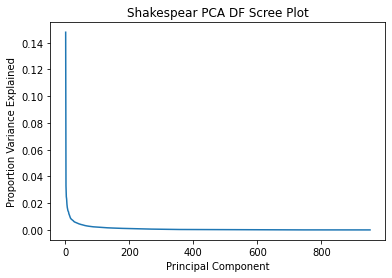

In [27]:
# Plot the explained variance using scree plot
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.title("Shakespear PCA DF Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

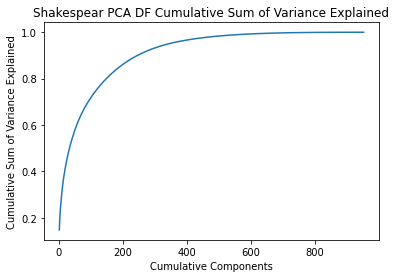

In [28]:
#Plot the explained variance using a culmulative plot
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title("Shakespear PCA DF Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

In [29]:
# Let's examine how much varaince is explained by each component
explained_var

DenseVector([0.1478, 0.033, 0.0249, 0.0231, 0.0192, 0.0169, 0.0156, 0.0144, 0.0139, 0.0134, 0.0121, 0.0116, 0.0109, 0.0102, 0.0096, 0.0088, 0.0086, 0.0082, 0.008, 0.0078, 0.0075, 0.0073, 0.0071, 0.007, 0.0068, 0.0064, 0.0063, 0.006, 0.0059, 0.0059, 0.0057, 0.0056, 0.0054, 0.0054, 0.0053, 0.0051, 0.005, 0.005, 0.0048, 0.0047, 0.0047, 0.0046, 0.0045, 0.0044, 0.0043, 0.0043, 0.0042, 0.0041, 0.004, 0.004, 0.004, 0.0039, 0.0038, 0.0038, 0.0037, 0.0036, 0.0036, 0.0035, 0.0034, 0.0033, 0.0033, 0.0032, 0.0032, 0.0031, 0.0031, 0.003, 0.003, 0.003, 0.0029, 0.0029, 0.0028, 0.0028, 0.0028, 0.0027, 0.0027, 0.0027, 0.0027, 0.0026, 0.0026, 0.0026, 0.0025, 0.0025, 0.0024, 0.0024, 0.0024, 0.0024, 0.0023, 0.0023, 0.0023, 0.0023, 0.0022, 0.0022, 0.0022, 0.0022, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.002, 0.002, 0.002, 0.002, 0.002, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.00

In [30]:
# Now let's iterate through the vector and find how many components we need to explain at least 90% of the variance
variance = 0
step = 0
for i in explained_var:
    variance = variance + i
    step = step + 1
    if (variance >= .90) : break
    #print(i)

print("Explained Variance:", variance)
print("Number of Components needed:", step)

Explained Variance: 0.900649705270449
Number of Components needed: 246


Analysis: With respect to choosing the number of components to use in PCA analysis, two good graphic tools are the scree plot and the cumulative sum of variance plot. In this case, with so many components, it is much easier to determine the desired number of components to consider using the cumulative plot. The cumulative plot shows the sum of variance captures as we include additional components. However, it' is still a little difficult to tell even with this plot so instead I wrote some custom code that iterated through the explained_var in order to find how many components I need to consider if I want 90% of the variance explained. I feel 90% is a satisfactory amount of variance given the context of the task. As my code shows that I should include 229 components. We can see the cumulative plot above shows this graphically as well if we imagine the intersection of two lines extending out of the y axis at 90, and the x axis at 229, they would intersect on our plotted line. Given this, I would reduce the number of components from 952 to 229 (while still being able to explain approximately 90% of the variance) in future analysis.

# Recommendation Funciton

This section provides code which makes recommendations on new characters to study based on a specific character that a Shakespeare fan likes.  The function is titled “get_nearest_chars” and it takes two arguments: char and num_nearest_chars. The char arg is a string which defines the character for which we are interested in finding similar characters. The num_nearest_chars arg is an integer that defines the total number of nearest characters which we want included in the return list. The get_nearest_chars function performs all of its internal operations in spark and returns a python list containing a string corresponding to each of the nearest characters defined by num_nearest_chars. The function computes the list of characters which are closest to the char arg using L2 Euclidian distance, based on two principle components.  I essentially fixed the number of PCA components to 2 so that we will limit the Euclidian distance to 2 dimensions for this problem.  The get_nearest_chars function rigorously error checks input data to verify that the user is not making illegal requests.

In [31]:
# Create function to provide recommendations
from pyspark.sql import types
import numpy as np

def get_nearest_chars(char, num_nearest_chars):
  # Error Checks
    charList = list(quotes_by_char_df.select("character").toPandas()["character"])
    if char not in charList:
        return print("We can't find the character you entered. Please check the spelling of your character name.")
    if len(char) == 0: # test to check if the chars is an empty set
        return print("Please enter a character to search for")
    if num_nearest_chars >= quotes_by_char_df.count(): # test to see if the arguement for num_neareast_chars exceeds the number of characters in the data
        return print("Please enter fewer characters to relate to.  Your current request would simply list all characters in the data.")
    if num_nearest_chars < 1: # test to see if the arguement for num_neareast_chars is at least 1
        return print("Please enter at least 1 character to recommend.")
    if not isinstance(num_nearest_chars, int):
        return print("Please enter an integer to search for nearest charaters")

  # Build a principal component object with 2 Principle Components
    pca_2 = feature.PCA(k=2, inputCol='centered_tfidf', outputCol='scores')

  # Create a pipeline estimator and fit it to the data
    pipe_pca_2 = Pipeline(stages=[pre_proc_pipe, pca_2]).fit(quotes_by_char_df)

  # Recommendation Function
    # Distance calc
    def L2_dist(c1, c2):    
        return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))
    L2_dist_udf = fn.udf(L2_dist, types.FloatType())
  
    #cross join fucntionality
    spark.sql("SET spark.sql.crossJoin.enabled=TRUE")

    # Character mapping
    df = (pipe_pca_2.transform(quotes_by_char_df).\
    where(quotes_by_char_df["character"] == char).\
    select(fn.col("scores").alias('character_score')).\
    join(pipe_pca_2.transform(quotes_by_char_df)).\
    withColumn('distance', L2_dist_udf('scores', 'character_score')).\
    select("character", "distance", 'scores', 'character_score').\
    orderBy(fn.asc("distance")).\
    select("character").\
    limit(num_nearest_chars+1))
    
    # Produce list of nearest characters
    df_pd = df.toPandas()
    bestChars = list(df_pd.iloc[1:,0].values)
    return bestChars

In [33]:
# Inspect the work
print(get_nearest_chars('romeo', 5))
print(get_nearest_chars('juliet', 5))


['duke vincentio', 'juliet', 'hamlet', 'prospero', 'king lear']
['duke vincentio', 'hamlet', 'romeo', 'mark antony', 'cleopatra']


## Now let's visualize realtionships

In [34]:
# Prepare a Juliet DF

# Re-run pip_pca_2 again since before it was run in a funtion
# Build a principal component object with 2 Principle Components
pca_2 = feature.PCA(k=2, inputCol='centered_tfidf', outputCol='scores')

# Create a pipeline estimator and fit it to the data
pipe_pca_2 = Pipeline(stages=[pre_proc_pipe, pca_2]).fit(quotes_by_char_df)

#cross join fucntionality
spark.sql("SET spark.sql.crossJoin.enabled=TRUE")

# Distance calc
def L2_dist(c1, c2):    
    return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))

L2_dist_udf = fn.udf(L2_dist, types.FloatType())

# Create DF
juliet_df = (pipe_pca_2.transform(quotes_by_char_df).\
    where('character == "juliet"').\
    select(fn.col("scores").alias('character_score')).\
    join(pipe_pca_2.transform(quotes_by_char_df)).\
    withColumn('distance', L2_dist_udf('scores', 'character_score')).\
    select("character", "distance", 'scores', 'character_score').\
    orderBy(fn.asc("distance")).\
    limit(10))


In [35]:
# prepare for plotting by getting the character names and scores
char_name = np.array(juliet_df.select('character').rdd.map(lambda x: x['character']).collect())
X = np.array(juliet_df.select('scores').rdd.map(lambda x: x['scores']).collect())
print("X.shape:", X.shape)

X.shape: (10, 2)


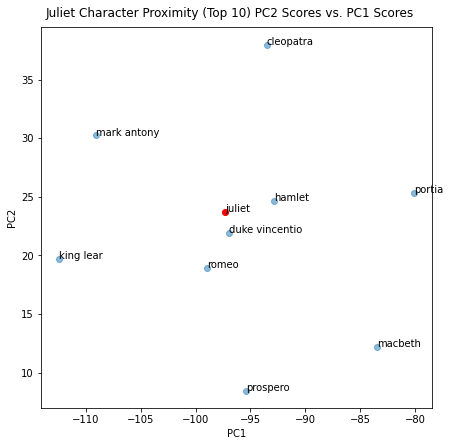

None

In [36]:
# Plot the data
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.scatter(X[:,0], X[:,1],alpha = 0.5)
ax.plot(X[0,0], X[0,1], 'ro')
fig.suptitle("Juliet Character Proximity (Top 10) PC2 Scores vs. PC1 Scores", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

for i, txt in enumerate(char_name):
    ax.annotate(txt, (X[i,0], X[i,1]))
    
display(plt.show())

## Now let's perform inference analysis on the 10 most and 10 least important words in the data set as defined by the absolute value of the PC1 loading vector coefficients.

In [37]:
# Extract the vocabulary
vocab = pipe_pca_2.stages[-2].stages[-3].vocabulary

In [38]:
# Extract the loadings
pca_model = pipe_pca_2.stages[-1]
pc1 = pca_model.pc.toArray()[:, 0].tolist() #Isolate PC

In [39]:
# Inspect the loadings
pc_loadings = pd.DataFrame([vocab, pc1]).T.rename(columns={0: 'word', 1: 'loading'})
print(pc_loadings.shape)

(4326, 2)


In [40]:
# Convert loading to absolute value as instructed
pc_loadings['loading'] = pc_loadings['loading'].abs()

In [41]:
# Most important words (Absolute value of PC1)
most_imp_df =  pc_loadings.sort_values('loading', ascending=False).head(10)

In [43]:
# Least important words (Absolute value of PC1)
least_imp_df  =  pc_loadings.sort_values('loading').head(10)

In [44]:
# Let's take a look
display(most_imp_df)
display(least_imp_df)

,word,loading
0,thou,0.285423
1,thy,0.206123
3,thee,0.180756
12,love,0.123597
7,o,0.115176
2,shall,0.114636
10,ill,0.100792
20,king,0.097936
8,come,0.0967992
9,let,0.0965018


,word,loading
1294,pyramus,0.000580211
3514,banks,0.000639008
4308,security,0.000758814
3983,fights,0.000763489
4299,labourd,0.000778994
4262,answering,0.000836044
3564,warning,0.000852918
3629,ale,0.000897731
3615,iii,0.000928793
3433,pursuit,0.000968587


Well I have to admit, I'm not much on Shakespeare so good inference will be a stretch…I’m sure a more sophisticated reader of Shakespeare can see much more in these results than me…but here goes…

The absolute value of the PCA loadings is a measure of how important or unimportant a term is. Rooted by the tfidf, it provides a score on how important a word is to a document in a collection or corpus of documents. Generally, PCA is a dimensionality reduction tool that helps to reorganize the internal correlation structure among a group of measurements displayed in a compact way. When there is common variance among the input variables (our words in this case) the loading of that variance gets placed into the first component. These loadings are similar to regression weights and correlation coefficients. The magnitude of how well each word connects with this synthesized new variable (PC1) can be determined by the absolute values captured above. We can see in the most_imp_df, these words load very strongly with PC1, but in least_imp_df ,these words load weaker with PC1. If we were to look at the second component, we would most likely see the low values loaded on that loading. Based on the way I pre-processed my data, and the parameters I selected during TF-IDF, we see words like thou, thy, love, king and alike are important. Which, with my limited experience with Shakespeare, I can say that sounds about right consider the way he wrote and the things he wrote about. Conversely, we see words ranked as least important like banks, fights, answering and alike, that clearly don’t sound much like Shakepseare at all and frankly, carry little meaning.


# Part 2: K-Means Clustering 

In this section I will compute K-Means silhouette scores for K = 2 through 6 on the PCA score data. I will train my model on each K 3 times to find the highest silhouette score. The silhouette score is a measure of within cluster variation. Because K-Means starts out with random cluster assignments, it is not guaranteed to find a global minima so I made multiple runs to find the lowest score. I will also plot the silhouette scores vs. K. 

In [45]:
# Based on what I learned ealier, I'm going to reduce my Components to 292 which allows me to explain 90% of variance while keeping things efficient

# Build a principal component object with the same number of components as k
pca_90 = feature.PCA(k=292, inputCol='centered_tfidf', outputCol='scores_90')

# Create a pipeline estimator and fit it to the data
pipe_pca_90 = Pipeline(stages=[pca_90]).fit(chars_pca_df)

# Transform
chars_pca_90_df = pipe_pca_90.transform(chars_pca_df)

In [46]:
from pyspark.ml.clustering import KMeans
# Even though the PCA column is the same units, I'll begin the K-Means process by creating a normalizing object so the vectors have the same length
norm = feature.Normalizer(inputCol="scores_90", outputCol="norm_scores_90", p=2.0)

In [47]:
# Create a new norm pipline
pipeline_norm = Pipeline(stages=[norm])

In [48]:
# Fit and transform
chars_pca_df_k = pipeline_norm.fit(chars_pca_90_df).transform(chars_pca_90_df)

In [49]:
#Create a loop in a loop to run through several k, several times
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silh_lst = []
r_table = chars_pca_df.select("character").toPandas()
k_list = range(2,7)


for k in k_list:
  sil_vals = []
  for run in range(1,4):
    # Train Model
    kmeans = KMeans().setK(k).setFeaturesCol('norm_scores_90').setPredictionCol('kmeans_feat').setInitSteps(3) # The initstep parameter initializes the random cluster centers n times and takes the highest score.
    model = kmeans.fit(chars_pca_df_k)
   
    # Predict
    predictions = model.transform(chars_pca_df_k)
    r_table['cluster_{k}_{run}'.format(k=k, run=run)]= predictions.select('kmeans_feat').toPandas()
    
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    evaluator.setPredictionCol("kmeans_feat")
    evaluator.setFeaturesCol("norm_scores_90")
    silhouette = evaluator.evaluate(predictions)
    sil_vals.append(silhouette)
  
  silh_array = np.asanyarray(max(sil_vals))
  silh_lst.append(silh_array)

  silhouette = pd.DataFrame(list(zip(k_list,silh_lst)),columns = ['k', 'max_silhouette'])

In [50]:
# Review the max silhoutte scores
silhouette

,k,max_silhouette
0,2,0.4905476828189594
1,3,0.4171471992339756
2,4,0.3806740659689137
3,5,0.31942512711712434
4,6,0.33418236734871903


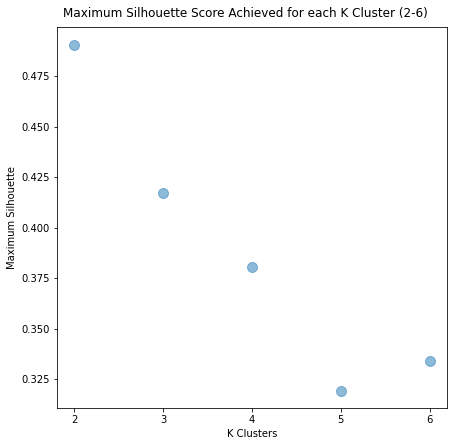

None

In [51]:
# Plot the data
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.scatter(silhouette["k"], silhouette["max_silhouette"], s = 100, alpha = 0.5)
fig.suptitle("Maximum Silhouette Score Achieved for each K Cluster (2-6)", y=.92)
plt.xticks(np.arange(2, 7, 1))
ax.set_xlabel("K Clusters")
ax.set_ylabel("Maximum Silhouette")
    
display(plt.show())

The cluster with the highest silhouette score is 2. This tells us a lot about the underlying data. Specifically, it tells us that despite their being so many characters in Shakespeare’s writings, its generally best to classify them into two different groups

Let’s expand the analysis and Perform K-Means clustering and plot the results using a scatter plot. The goal of will be to try to find an interesting insight about the Shakespeare characters. I will color the points by cluster assignment. Based on my discoveries above, I will generate two clusters and plot the observation data in 2 dimensions by using PC1 and PC2 as the X and Y coordinates. 

In [52]:
# Continuing with tearlier work, I'll begin by extracting the first two components and move them into thier own colums
from pyspark.ml.feature import VectorSlicer

# #Create a vector Slicer to braeak up the PCA scores
PCA1_slicer = VectorSlicer(inputCol="norm_scores_90", outputCol="PCA1", indices=[0])
PCA2_slicer = VectorSlicer(inputCol="norm_scores_90", outputCol="PCA2", indices=[1])

# Fit the pipe
pca_plot_norm_pipe = Pipeline(stages=[PCA1_slicer,PCA2_slicer]).fit(chars_pca_df_k)

# Fit, Transform and create new df
pca_plot_norm_df = pca_plot_norm_pipe.transform(chars_pca_df_k)

In [53]:
# Inspect the DF
pca_plot_norm_df.show(5)

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  character|          all_quotes|      all_quotes_Out|            filtered|                  tf|               tfidf|      centered_tfidf|              scores|           scores_90|      norm_scores_90|                PCA1|                PCA2|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     a lord|       sir it was i |   [sir, it, was, i]|               [sir]|    (4326,[6],[1.0])|(4326,[6],[0.7693...|[-3.8421384319495...|[15.9365442099680...|[15.9365442099680...|[0.98612429947436...|[0.9861242994743697]|[-0.0694128004725...|
|   a player|so plea

In [54]:
# Conduct K-means with the most perfomant set-up from Q7 (2 clusters, 1 initStep)

# Train Model
kmeans = KMeans().setK(2).setFeaturesCol('norm_scores_90').setPredictionCol('kmeans_cluster').setInitSteps(1) # The initstep parameter initializes the random cluster centers n times and takes the lowest score.
model = kmeans.fit(pca_plot_norm_df)
   
# Predict
predictions = model.transform(pca_plot_norm_df)
predictions_reduced = predictions.select("character","PCA1", "PCA2","kmeans_cluster" )

In [55]:
# Inspect the DF
predictions_reduced.show(5)
predictions_reduced.printSchema()

+-----------+--------------------+--------------------+--------------+
|  character|                PCA1|                PCA2|kmeans_cluster|
+-----------+--------------------+--------------------+--------------+
|     a lord|[0.9861242994743697]|[-0.0694128004725...|             0|
|   a player|[0.9774598818877946]|[-0.0817105375486...|             0|
|      aaron|[-0.3123139619707...|[-0.0193355223619...|             1|
|abergavenny|[0.9468794703723072]|[-0.1020699288970...|             0|
|    abraham|[0.9734101653431423]|[-0.0462168675472...|             0|
+-----------+--------------------+--------------------+--------------+
only showing top 5 rows

root
 |-- character: string (nullable = true)
 |-- PCA1: vector (nullable = true)
 |-- PCA2: vector (nullable = true)
 |-- kmeans_cluster: integer (nullable = false)



In [56]:
# UDF for converting column type from vector to double type to assist with plotting
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

unlist = udf(lambda x: float(list(x)[0]), DoubleType())

predictions_reduced = predictions_reduced.withColumn("PCA1_new", unlist("PCA1"))
predictions_reduced = predictions_reduced.withColumn("PCA2_new", unlist("PCA2"))

# I'll also round the values
predictions_reduced = predictions_reduced.withColumn("PCA1_new", (fn.round(predictions_reduced["PCA1_new"], 8)))
predictions_reduced = predictions_reduced.withColumn("PCA2_new", (fn.round(predictions_reduced["PCA2_new"], 8)))

predictions_final = predictions_reduced.select("character","PCA1_new", "PCA2_new","kmeans_cluster" )

predictions_final.show(5)
predictions_final.printSchema()

+-----------+-----------+-----------+--------------+
|  character|   PCA1_new|   PCA2_new|kmeans_cluster|
+-----------+-----------+-----------+--------------+
|     a lord|  0.9861243| -0.0694128|             0|
|   a player| 0.97745988|-0.08171054|             0|
|      aaron|-0.31231396|-0.01933552|             1|
|abergavenny| 0.94687947|-0.10206993|             0|
|    abraham| 0.97341017|-0.04621687|             0|
+-----------+-----------+-----------+--------------+
only showing top 5 rows

root
 |-- character: string (nullable = true)
 |-- PCA1_new: double (nullable = true)
 |-- PCA2_new: double (nullable = true)
 |-- kmeans_cluster: integer (nullable = false)



In [57]:
# Identify the cluster centers
cluster_0 = model.clusterCenters()[0]
cluster_1 = model.clusterCenters()[1]

In [100]:
# I created this code aftet the initial plot to meet the requirements of the quesition by denoting insights on the plot
# Find outliers
# Build scoping logic
outlier_logic = ((predictions_final["PCA1_new"]  < -60) | (predictions_final["PCA2_new"] > 0.3) | (predictions_final["PCA2_new"] < -0.4) | ((predictions_final["PCA2_new"] < -0.29) &  (predictions_final["PCA1_new"]  > 0.25)))

# Scope the DF using logic
predictions_scope = predictions_final[outlier_logic]

# Review the scoped DF
predictions_scope_pd = predictions_scope.toPandas()


#ID center of gravity chartacters for cluster 0
c0_logic = (((predictions_final["PCA1_new"]  < 0.86) & (predictions_final["PCA1_new"]  > 0.84)) & ((predictions_final["PCA2_new"] < -0.08) & (predictions_final["PCA2_new"] > -0.1)))

# Scope the DF using logic
c0_scope = predictions_final[c0_logic]

# Review the scoped DF
c0_scope_pd = c0_scope.toPandas()



#ID center of gravity chartacters for cluster 1
c1_logic = (((predictions_final["PCA1_new"]  > -0.2) & (predictions_final["PCA1_new"]  < -0.18)) & ((predictions_final["PCA2_new"] < -0.10) & (predictions_final["PCA2_new"] > -0.13)))


# Scope the DF using logic
c1_scope = predictions_final[c1_logic]

# Review the scoped DF
c1_scope_pd = c1_scope.toPandas()




In [96]:
# Review the logic DFs
predictions_scope_pd

,character,PCA1_new,PCA2_new,kmeans_cluster
0,basset,0.739216,-0.314422,0
1,green,0.693042,-0.345829,0
2,henry percy,0.500251,-0.309738,0
3,prince edward,0.172314,-0.450117,1
4,york,-0.524091,-0.560293,1
5,king henry vi,-0.576433,-0.536384,1
6,oxford,0.553947,-0.459711,0
7,post,0.609627,-0.386946,0
8,queen margaret,-0.595835,-0.491838,1
9,warwick,-0.491575,-0.603119,1


In [82]:
# Review the logic DFs
c0_scope_pd

,character,PCA1_new,PCA2_new,kmeans_cluster
0,hymen,0.844693,-0.089698,0


In [101]:
# Review the logic DFs
c1_scope_pd

,character,PCA1_new,PCA2_new,kmeans_cluster
0,king philip,-0.197076,-0.127655,1


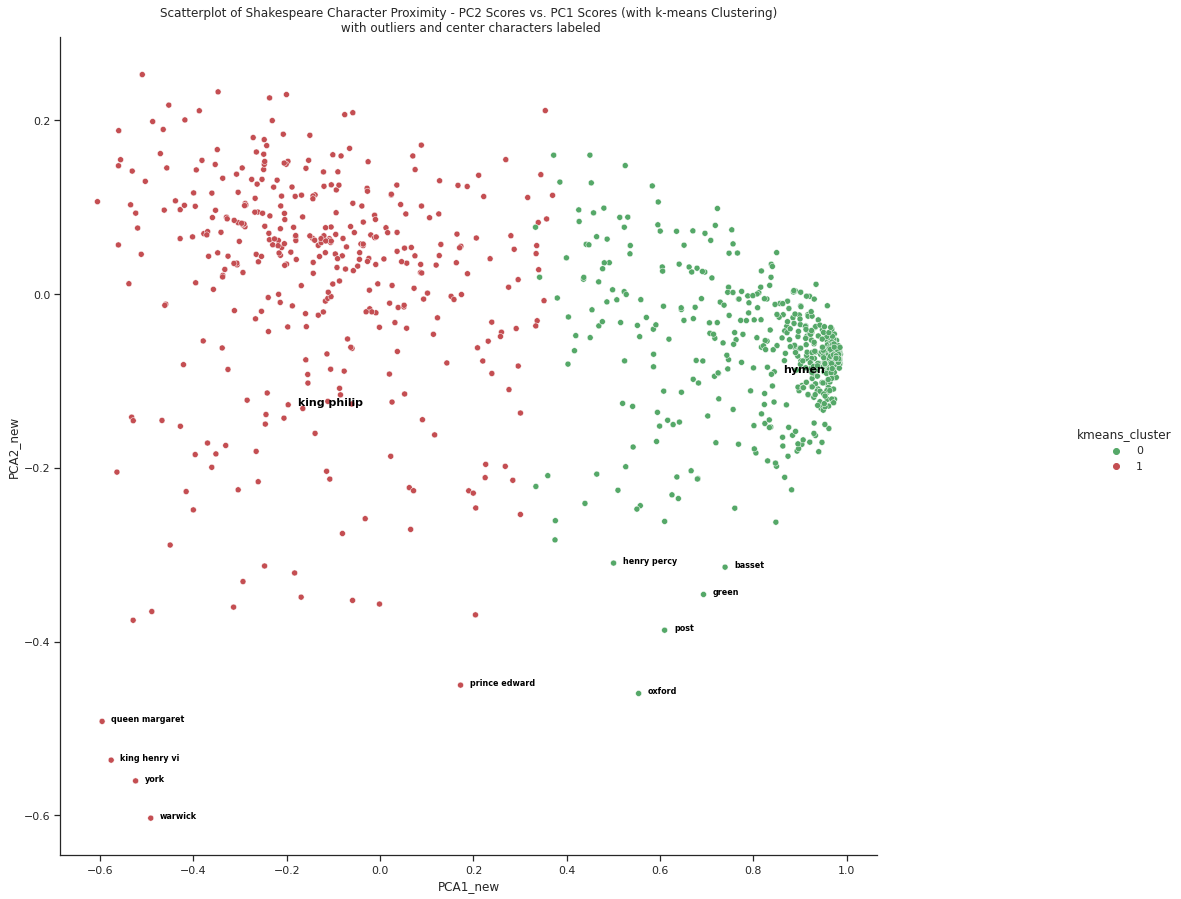

In [102]:
# And let's plot
import seaborn as sns
sns.set(style="ticks")


# Plot 1
p2 = sns.relplot(x="PCA1_new", y="PCA2_new",hue="kmeans_cluster", palette = ['g','r'], data= predictions_final.toPandas())
p2.ax.xaxis.grid(True, "minor", linewidth=.25)
p2.ax.yaxis.grid(True, "minor", linewidth=.25)
p2.ax.set_title("Scatterplot of Shakespeare Character Proximity - PC2 Scores vs. PC1 Scores (with k-means Clustering)\n with outliers and center characters labeled")
p2.fig.set_size_inches(18,13)
 
for line in range(0,predictions_scope_pd.shape[0]):
     p2.ax.text(predictions_scope_pd.PCA1_new[line]+0.02, predictions_scope_pd.PCA2_new[line], predictions_scope_pd.character[line],
                horizontalalignment='left', size='medium', color='black', weight='semibold', fontsize=8)
     
for char1 in range(0,c0_scope_pd.shape[0]):
     p2.ax.text(c0_scope_pd.PCA1_new[char1]+0.02, c0_scope_pd.PCA2_new[char1], c0_scope_pd.character[char1],
                horizontalalignment='left', size='medium', color='black', weight='semibold', fontsize=11)
     
for char2 in range(0,c1_scope_pd.shape[0]):
     p2.ax.text(c1_scope_pd.PCA1_new[char2]+0.02, c1_scope_pd.PCA2_new[char2], c1_scope_pd.character[char2],
                horizontalalignment='left', size='medium', color='black', weight='semibold', fontsize=11)

display(p2)

The work in the plot above is based on what was learned from earlier parts of this notebook.  As illustrated in previously, based on the way I preprocessed the data, I was able to explain 90% of the variance with 292 components.  I also demonstrated that the best way to maximize our silhouette score is to conduct cluster analysis with two cluster.  Taking these into consideration, I have created the above 2 dimensional plot using PCA1 which accounts for 0.17 percent of variance for the X-axis, and PCA2 which accounts for 0.03 percent of the variance as the Y axis.  Using this construct we see several distinctions emerge.

Perhaps the most prominent thing we see is that there are clearly two distinct clusters of Shakespeare character: cluster 0 on green and cluster 1 in red. Graphically they appear to make up about the same amount of characters, but we can clearly see that the variation in cluster 0 is much less than that of cluster 1.  This dispersion suggests that the characters in cluster 0 are tightly related, while the characters in cluster 1 are not.  For example, we see charter “hyman” is one of the central characters in cluster 0.  We also see that character “king philip” is one of the central characters in cluster 0.  These characters sever as a sort of center of gravity for the cluster which tells us that based on things these characters say (at least according to our dataset), the other characters near them are similar to them.  My original hypothesis was that perhaps cluster 0 centered on good people, and cluster 1 centered on villains, however, after further investigation that did not hold.

We can also see that in both cluster 0 and in cluster 1 there are some characters that are far from the center of each cluster.  These characters could be considered outliers and are denoted with labels for their names.  Without additional data to provide context, there are limited conclusions we can draw about the fact that they are so far away from their center.  It is interesting to note however, that cluster 1 has many more outlying characters than cluster 0. Knowing more about these characters would help tell the story between these two clusters.
